In [1]:
import numpy as np
from scipy.stats import bernoulli
import matplotlib as plt
from matplotlib import pyplot
import random 

In [3]:
class BernoulliBandit :
    def __init__ (self , means):
        for i in means:
            assert(i <= 1 and i >= 0)
        self.means = means
        self.k = len(means)
        self.best_mean = max(means)
        self.regret = 0
# Function should return the number of arms
    def get_K( self ):
         return self.k
# Accepts a parameter 0 <= a <= K -1 and returns the
# realisation of random variable X with P(X = 1) being
# the mean of the (a +1) th arm .
    def pull (self , a):
        self.regret += (self.best_mean - self.means[a])
        return bernoulli.rvs(self.means[a], size=1)

    def get_regret ( self ):
        return self.regret

In [24]:
class GaussianBandit :
    def __init__ (self , means):
        self.means = means
        self.k = len(means)
        self.best_mean = max(means)
        self.regret = 0
        
    def pull (self , a):
        self.regret += (self.best_mean - self.means[a])
        return random.gauss(self.means[a], 1)


In [22]:
def ETC(n, m, bandit): ##Explore then commit algorithm
    k = bandit.k
    rewards= np.zeros(n)
    total_reward=0
    actions = np.zeros(n)
    for i in range(n):
        if(i<= m*k - 1):
            rewards[i] = bandit.pull(i%k)
            total_reward += rewards[i]
            actions[i] = i%k
        else: 
            if(i == m*k): ##optimization
                best_mean_index = np.argmax(np.mean(np.transpose(np.reshape(rewards[0:m*k], (m,k))),1))
            actions[i] = best_mean_index
            rewards[i] = bandit.pull(best_mean_index)
            total_reward += rewards[i]
    random_regret = n * bandit.best_mean - total_reward
    return np.array([(i,j) for (i,j) in zip(actions,rewards)]), random_regret ## returns a list of a_t, x_t pairs and the observed random regret
    

In [4]:
bandit = BernoulliBandit([0.3,0.6,0.9])
ETC(100,5,bandit)[0][0:20]

array([[0., 1.],
       [1., 1.],
       [2., 1.],
       [0., 0.],
       [1., 1.],
       [2., 1.],
       [0., 1.],
       [1., 1.],
       [2., 1.],
       [0., 0.],
       [1., 1.],
       [2., 1.],
       [0., 1.],
       [1., 1.],
       [2., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.]])

In [ ]:
trials = 100
horizon = 500
mean_regrets = np.zeros(50)
for m in range(2,101,2): ## m = [2,4,...,50]
    for i in range(trials):
        bandit= BernoulliBandit([0.5,0.6,0.7])
        results, observed_random_regret = ETC(horizon,m,bandit)
        mean_regrets[int(m/2) - 1] = (mean_regrets[int(m/2) - 1] * i + bandit.get_regret())/(i+1) 

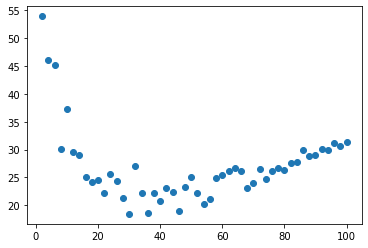

In [91]:
pyplot.scatter(range(2,101,2), mean_regrets)

In [4]:
def eps_greedy(epsilons, bandit): ##epsilon greedy algorithm
    k = bandit.k
    means = np.zeros(k)
    n_times_pulled = np.ones(k)
    n = len(epsilons) ##horizon is number of arms + length of sequence given
    bools = np.random.uniform(0,1,len(epsilons)) > epsilons ##the sequence of Bernoulli(1-eps) random variables
    actions = np.zeros(n + k)
    rewards = np.zeros(n + k)
    for i in range(k):
        means[i] = bandit.pull(i)
        actions[i] = i
        rewards[i] = means[i]
    for i in range(n):
        if(bools[i]):
            rewards[i + k] = bandit.pull(np.argmax(means))
            actions[i + k] = np.argmax(means)
            means[np.argmax(means)] = (means[np.argmax(means)]*n_times_pulled[np.argmax(means)] + rewards[i + k])/(n_times_pulled[np.argmax(means)]+1)
            n_times_pulled[np.argmax(means)]+=1
        else:
            arm = random.randint(0,k-1)
            rewards[i + k] = bandit.pull(arm)
            actions[i + k] = arm
            means[arm] = (means[arm]*n_times_pulled[arm] + rewards[i + k])/(n_times_pulled[arm]+1)
            n_times_pulled[arm]+=1
    return np.array([(i,j) for (i,j) in zip(actions,rewards)]), bandit.regret ##returns a list of a_t, x_t pairs and pseudo-regret 

In [10]:
trials = 20
avg_regrets = []
eps_ = np.linspace((0.6,0.1),(0.3,0.1), 100) 
for i,j in eps_:
    regrets= np.zeros(trials)
    for i in range(trials):
        eps = np.linspace(i,j,1000)
        bandit= BernoulliBandit([0.5,0.6,0.7])
        results, regret = eps_greedy(eps,bandit)
        regrets[i] = regret
    avg_regrets.append(np.mean(regrets))

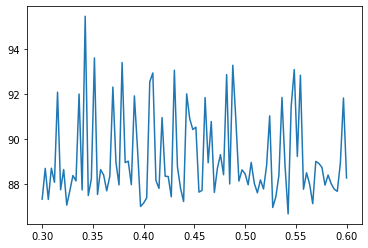

In [11]:
pyplot.plot(eps_[:,0],avg_regrets)

# Exercises

## 6.1
$\hat{\mu}_i(mk) = \frac{1}{T_i(mk)}\sum^{mk}_{s=1}\mathbb{1}(A_s=1)X_s$
By the canonical model, every non-zero term in the sum is drawn from $\mathbb{P}_{A_i}(.)$ distribution which is 1-subgaussian. And by the algorithm there are m non-zero terms.
show that $\frac{1}{m}(\sum^m_1X_t + \sum^m_1X_1)$ is $\sqrt{\frac{2}{m}}-subgaussian$.
How to deal with the added constant?

## 6.2
### Case 1:
$\Delta \leq \frac{1}{\sqrt{n}}$:

$R_n \leq n\Delta \leq \sqrt{n}$

### Case 2:
$\Delta \geq \frac{1}{\sqrt{n}}$:

$R_n \leq \Delta + \frac{4}{\Delta}\Bigl(1+max\{0, log(\frac{n\Delta^2}{4})\}\Bigr)$

$R_n \leq \Delta + 4\sqrt{n} + \max_{\Delta'>0}\frac{4}{\Delta'}log(\frac{n\Delta'^2}{4})$

Finding the first derivative for the right-most term and equating to 0:

$\frac{8}{\Delta'^2}-\frac{4}{\Delta'^2}log(\frac{n\Delta'^2}{4}) = 0$

Evaluting, we get $\Delta' = \frac{2e}{\sqrt{n}}$

Can check that the second derivate is negative.

Substituting, we get:

$R_n \leq \Delta + 4\sqrt{n} + \frac{4\sqrt{n}}{e} \leq \Delta + (4+\frac{4}{e})\sqrt{n}$


# 6.3

Assuming that n>2m, and let $\Delta_2$ be the suboptimality gap of the suboptimal arm, we have that:

$\mathbb{P}(T_2(n)>m) \leq \mathbb{P}(\hat{\mu}_2(2m) - \hat{\mu_2} + \mu_1 - \mu_2 \geq \Delta_2) \leq exp(-\frac{m\Delta^2}{4})$ as seen before.

Setting $m = \frac{4}{\Delta^2}log(\frac{1}{\delta})$ would yield:

$\mathbb{P}(T_2(n) >m) \leq \delta$

We thus have the bound on the pseudo-regret with probability 1-$\delta$:

$\bar{R}_n \leq m\Delta_2 = \frac{4}{\Delta_2}log(\frac{1}{\delta})$


# 6.4

We need:
$\mathbb{P}(n\mu^*-\sum^n_{t=1}X_t \leq \epsilon) = 1- \delta$
We have that:

$\mathbb{P}(n\mu^*-\sum^n_{t=1}X_t \leq \epsilon) = \mathbb{P}(\sum^n_{t=1}X_t - n\mu^* \geq -\epsilon) \leq exp(-\frac{(\epsilon)^2}{2n})$ 

Since $\sum^n_{t=1}X_t - n\mu^*$ is $\sqrt{n}-subgaussian$.

setting $\epsilon = \sqrt{2nlog(\frac{1}{1-\delta})}$ will give us the bound:
$R_n < \sqrt{2nlog(\frac{1}{1-\delta})}$ with probability $1-\delta$

We conclude that the $1-\delta$-probaility bound for the random regret is in O($\sqrt{n}$) whereas for the pseudo-regret, it is in O(1). 

## 6.5
## a) 
Let $N_0$ =0 and for $\mathcal{l}$>1 let $N_\mathcal{l}=min(N_{\mathcal{l}-1}+n_\mathcal{l},n),T_\mathcal{l}=\{N_{\mathcal{l}-1}+1,...,n_\mathcal{l}\}$. Policy $\pi$ is used with horizon $n_\mathcal{l}$ on interval $T_\mathcal{l}$. We thus have:

$$R_n(\pi^*, \mathcal{v}) = \sum^{\mathcal{l}_{max}}_{\mathcal{l}=1}R_{|T_\mathcal{l}|}(\pi(n_\mathcal{l}),\mathcal(v))\leq \sum^{\mathcal{l}_{max}}_{\mathcal{l}=1}max_{1\leq t\leq n_{\mathcal{l}}}R_t(\pi(n_\mathcal{l}),\mathcal(v)) \leq \sum^{\mathcal{l}_{max}}_{\mathcal{l}=1} f_{n_\mathcal{l}}(\mathcal{v})$$

# 6.9

In [21]:
def m_max(n, delta):
    m= np.max([1, (4/delta**2) * np.log(n*delta**2/4)])
    return m


In [25]:
expected_regrets = []
for m in range(10,400,5):
    regrets = np.zeros(100)
    for i in range(100):
        bandit = GaussianBandit([0,-0.1])
        results, regret = ETC(100,m,bandit)
        regrets[i] = regret
    expected_regrets.append(np.mean(regrets))

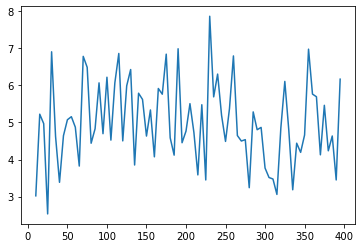

In [27]:
pyplot.plot(range(10,400,5), expected_regrets)